## Introduction
TODO: Yiyi writes outline here.

## Reading data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import itertools
import random

# Reading data
biyashee_colony_cnts = pd.read_csv('data/Bishayee Colony Counts 10.27.97-3.8.01.csv', skiprows=2)
biyashee_coulter_cnts = pd.read_csv('data/Bishayee Coulter Counts.10.20.97-7.16.01.csv', skiprows=1)
other_colony_cnts = pd.read_csv('data/Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.csv', skiprows=1)
other_coulter_cnts = pd.read_csv('data/Other Investigators in Lab.Coulter Counts.4.15.92-5.21.05.csv', skiprows=1)
outside_coulter_cnts1 = pd.read_csv('data/Outside Lab 1.Coulter Counts.6.7.91-4.9.99.csv')
outside_coulter_cnts2 = pd.read_csv('data/Outside Lab 2.Coulter Counts.6.6.08-7.7.08.csv', skiprows=1)
outside_colony_cnts =  pd.read_csv('data/Outside Lab 3.Colony Counts.2.4.10-5.21.12.csv', skiprows=1)

# standardizing column names for dataframes
biyashee_colony_cnts.columns = ['Isotope', 'Bates', 'Date', 'c1', 'c2', 'c3', 'avg']
biyashee_coulter_cnts.columns = ['Bates', 'Date', 'c1', 'c2', 'c3', 'avg']
other_colony_cnts.columns = ['Bates', 'Date', 'Inv', 'c1', 'c2', 'c3', 'avg']
other_coulter_cnts.columns = ['Bates', 'Date', 'c1', 'c2', 'c3', 'avg', 'Inv']
outside_coulter_cnts1.columns = ['Experiment', 'c1', 'c2', 'c3', 'avg', 'Date']
outside_coulter_cnts2.columns = ['Date', 'c1', 'c2', 'c3', 'avg']
outside_colony_cnts.columns = ['Date', 'c1', 'c2', 'c3', 'avg']

# converting to numerics
biyashee_colony_cnts['c3'] = pd.to_numeric(biyashee_colony_cnts['c3'], errors = 'coerce')
other_colony_cnts['c3'] = pd.to_numeric(other_colony_cnts['c3'], errors = 'coerce')

# filling in experiment and date info
def fill_na(df, column):
    df[column] = df[column].fillna(method='ffill')

fill_na(outside_coulter_cnts1, 'Experiment')
fill_na(outside_coulter_cnts1, 'Date')
fill_na(outside_coulter_cnts2, 'Date')
fill_na(outside_colony_cnts, 'Date')

## Triplicate Mean Count
### Replication
#### Hypothesis Testing 1

In [2]:
p = 0.42

n_triplicate_containing_avg = 690
n_samples = 1343
prob = stats.binom.sf(n_triplicate_containing_avg - 1, n_samples, p)
print 'RTS data: ', format(prob, '1.3E')

n_triplicate_containing_avg = 109
n_samples = 572
prob = stats.binom.sf(n_triplicate_containing_avg - 1, n_samples, p)
print 'Rest of the lab: ', format(prob, '1.3E')

RTS data:  2.853E-12
Rest of the lab:  1.000E+00


### Alternative Analysis: Permutation Test
Step 1. Pool all the samples together. We only took the triplicate counts and recomputed the average in the next step.

In [3]:
# pool all samples for triplicate testing:
def triplicate_pool_all_samples(dfs):
    samples = dfs[0][['c1', 'c2', 'c3']]
    for df in dfs[1:]:
        samples = samples.append(df[['c1', 'c2', 'c3']], ignore_index=True)
    return samples

coulter_dfs = [biyashee_coulter_cnts,
               other_coulter_cnts,
               outside_coulter_cnts1,
               outside_coulter_cnts2]

colony_dfs = [biyashee_colony_cnts,
              other_colony_cnts,
              outside_colony_cnts]

coulter_samples = triplicate_pool_all_samples(coulter_dfs)
colony_samples = triplicate_pool_all_samples(colony_dfs)

Step 2. Calculate the average and check if each triplicate contains the mean for the pooled samples.

In [4]:
import warnings
warnings.filterwarnings('ignore')

def contains_mean(df_row):
    '''returns true if any of c1, c2 or c3 equals the triplicate average '''
    return (df_row['mean'] == df_row['c1'] or 
            df_row['mean'] == df_row['c2'] or 
            df_row['mean'] == df_row['c3'])

# clean up data and add a new column to the data frame indicating if the triplicate contains its rounded mean
def triplicate_has_mean(df):
    '''append df with an extra column of booleans indicating if each row of triplicate contains its own mean'''
    # drop NA values and convert c1, c2, c3 to int type
    df = df.dropna()
    df[['c1', 'c2', 'c3']] = df[['c1', 'c2', 'c3']].astype(int)
    
    # calculate mean and append a new column of mean values to df
    df['mean'] = df.mean(axis=1).round(0).astype(int)

    # calculate if each row of triplicate contains its own mean and append a new boolean column to df
    # df['contains_mean'] = df.apply(lambda x: contains_mean(x), axis=1)
    df['contains_mean'] = df.apply(contains_mean, axis=1)
    
    return df

coulter_samples_mean = triplicate_has_mean(coulter_samples)
colony_samples_mean = triplicate_has_mean(colony_samples)

Step 3. Permutation test for triplicate count test.

In [5]:
def tri_perm_test(pooled_samples, n, test_statistic):
    '''permutation test for triplicate mean counts
    pooled_samples should be a series'''
    
    # rv is the hypergeometric variable in question
    rv = stats.hypergeom(pooled_samples.size, pooled_samples.sum(), n)
    
    # Plotting a sample draw (optional)
    (lower, upper) = rv.interval(0.9999)
    x = np.arange(lower, upper)
    plt.plot(x, rv.pmf(x))
    
    # pooled_samples.size is the total number of triplets
    # pooled_samples.sum() is the number of marked triplets
    # n is the number of sampels drawn
    return rv.sf(test_statistic - 1)

Step 4a. Perform the permutation test on coulter samples.

Permutation Test on Coulter Samples
Size of sameple:  1716
Test statistic:  173
Probability that sample permutation >= test statistic:  6.586E-12


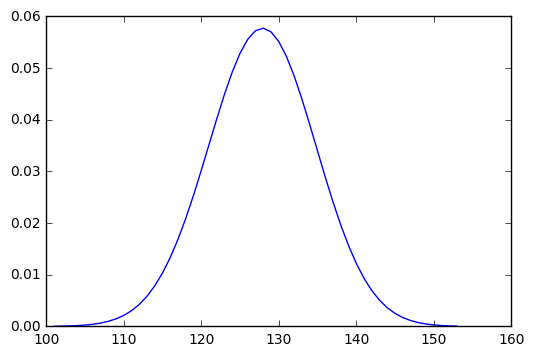

In [6]:
# values of n and test_statistic are obtained from PNAS paper Table 2 (pg 7)
n = 1716
test_statistic = 173

# permutation test on coulter samples (and plot the distribution histogram)
test_result = tri_perm_test(coulter_samples_mean['contains_mean'], n, test_statistic)

# print out key information as output
print "Permutation Test on Coulter Samples"
print "Size of sameple: ", n
print "Test statistic: ", test_statistic
print "Probability that sample permutation >= test statistic: ", format(test_result, '1.3E')

Step 4b. Perform the permutation test on colony samples.

Permutation Test on Colony Samples
Size of sameple:  1343
Test statistic:  690
Probability that sampled permutation >= test statistic:  1.781E-36


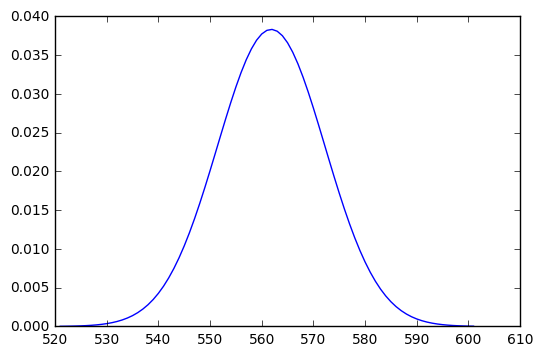

In [7]:
# values of n and test_statistic are obtained from PNAS paper Table 2 (pg 7)
n = 1343
test_statistic = 690

# permutation test on coulter samples (and plot the distribution histogram)
test_result = tri_perm_test(colony_samples_mean['contains_mean'], n, test_statistic)

# print out key information as output
print "Permutation Test on Colony Samples"
print "Size of sameple: ", n
print "Test statistic: ", test_statistic
print "Probability that sampled permutation >= test statistic: ", format(test_result, '1.3E')

## Terminal digits analysis
### Testing the assumptions
#### Is the terminal digit of a Poisson variable uniform?
For each `mu`, we compute its total variation distance of the terminal digit distribution again the uniform distribution. We generate a vector containing 99.9% its probability mass. We reshape it into an array with 10 columns, allowing us to add the probability mass by terminal digits.

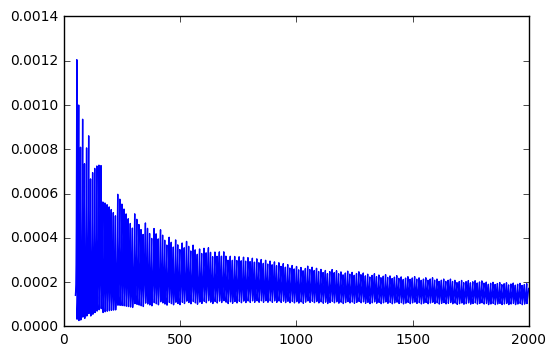

In [8]:
def termd_poisson_tv(mu):
    '''computes the total variation distance of the terminal digit distribution against uniform'''
    # Computes the probability mass, tail probability disregarded
    num_comp = np.ceil(stats.poisson.ppf(0.999, mu) / 10) * 10
    prob = stats.poisson.pmf(np.arange(num_comp), mu)
    # Normalization by 1-norm
    prob = prob / np.linalg.norm(prob, 1)
    # Reshaping prob into 10 columns so each row can be added
    prob = np.reshape(prob, (-1, 10))
    return np.linalg.norm(prob.sum(axis=0) - np.ones(10) / 10, 1)

v_termd_poisson_tv = np.vectorize(termd_poisson_tv)
# Range of mu we are plotting
x = np.arange(50, 2000)
plt.plot(x, v_termd_poisson_tv(x))

As observed above, the total variation distance is moderately close to 0. (The lack of convergence to 0 is due to the a truncated Poisson distribution is used in computation.) This validates the assumption.

#### Is the last two digits of a Poisson variable, conditioned on being three or more digits, the same approximately 10% of the time?

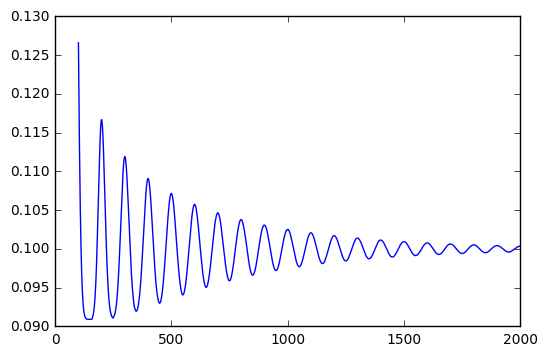

In [9]:
def term2d_poisson_tv(mu):
    '''computes the total variation distance of the terminal digit distribution against uniform'''
    # Computes the probability mass, tail probability disregarded
    num_comp = np.ceil(stats.poisson.ppf(0.999, mu) / 100) * 100
    prob = stats.poisson.pmf(np.arange(100, num_comp), mu)
    # Normalization by 1-norm
    prob = prob / np.linalg.norm(prob, 1)
    # Reshaping prob into 10 columns so each row can be added
    prob = np.reshape(prob, (-1, 100))
    return np.sum(prob[:, 0:100:11])

v_term2d_poisson_tv = np.vectorize(term2d_poisson_tv)
# Range of mu we are plotting
x = np.arange(100, 2000)
plt.plot(x, v_term2d_poisson_tv(x))

Since a lot of the counts by RTS is around 100, the assumption of 10% is not very valid in this regime. This is porticularly troublesome when the true parameter $\lambda$ is smaller than or comparable to 100. It is significantly more likely to observe 100 than 111, upsetting the uniform distribution assumption. Subject to imprecision of model specification, it does not seem that unlikely that RTS has a ~12% matching last two digits.

### Replication

In [10]:
def termd_count(df):
    '''counts the terminal digit in dataframe df. df must have c1, c2, c3'''
    c1_termd = df['c1'].mod(10).value_counts().sort_index()
    c2_termd = df['c2'].mod(10).value_counts().sort_index()
    c3_termd = df['c3'].mod(10).value_counts().sort_index()
    return list(c1_termd + c2_termd + c3_termd)

# corresponds to table 3 in Pitt and Hill
table3 = pd.DataFrame([termd_count(biyashee_colony_cnts),
                       termd_count(biyashee_coulter_cnts),
                       termd_count(other_colony_cnts),
                       termd_count(other_coulter_cnts),
                       termd_count(outside_coulter_cnts1),
                       termd_count(outside_coulter_cnts2),
                       termd_count(outside_colony_cnts)],
                      columns = range(10))
table3['index'] = pd.Series(['biyashee_colony_cnts', 'biyashee_coulter_cnts',
                             'other_colony_cnts', 'other_coulter_cnts',
                             'outside_coulter_cnts1', 'outside_coulter_cnts2',
                             'outside_colony_cnts'],
                            index=table3.index)
table3.set_index('index', inplace=True)
table3.index.name = None
table3['total'] = table3.sum(axis=1)
table3['chi-square'] = 0
for i in range(10):
    table3['chi-square'] += (table3[i] - table3['total'] / 10) ** 2 / (table3['total'] / 10)
table3['p'] = stats.chisqprob(table3['chi-square'], 9)
print(table3)

                         0    1    2    3    4    5    6    7    8    9  \
biyashee_colony_cnts   564  324  463  313  290  478  336  408  383  526   
biyashee_coulter_cnts  475  613  736  416  335  732  363  425  372  718   
other_colony_cnts      191  181  195  179  184  175  178  185  185  181   
other_coulter_cnts     261  311  295  259  318  290  298  283  331  296   
outside_coulter_cnts1   28   34   29   25   27   36   44   33   26   33   
outside_coulter_cnts2   34   38   45   35   32   42   31   35   35   33   
outside_colony_cnts     21    9   15   16   19   19    9   19   11   12   

                       total  chi-square             p  
biyashee_colony_cnts    4085  200.725826  2.333780e-38  
biyashee_coulter_cnts   5185  466.874638  7.062273e-95  
other_colony_cnts       1834    1.790622  9.943625e-01  
other_coulter_cnts      2942   15.994562  6.699524e-02  
outside_coulter_cnts1    315    9.476190  3.945273e-01  
outside_coulter_cnts2    360    4.944444  8.391240e-01  


Although the `total` column in the paper does not add up correctly, fixing it did not change the p-values much.

### Alternative analysis: Permutation test

In [11]:
# pool all samples:
def pool_all_samples(dfs):
    samples = np.array([])
    for df in dfs:
        samples = np.append(samples,df[['c1','c2','c3']].values.flatten())
    return samples

coulter_dfs = [biyashee_coulter_cnts,
               other_coulter_cnts,
               outside_coulter_cnts1,
               outside_coulter_cnts2]

colony_dfs = [biyashee_colony_cnts,
              other_colony_cnts,
              outside_colony_cnts]


coulter_samples = pool_all_samples(coulter_dfs)
colony_samples = pool_all_samples(colony_dfs)

In [12]:
def chi_squared_term_digit(samples):
    chi_squared = 0
    termd = samples%10
    for i in range(10):
        ni = np.count_nonzero(termd == i)
        N = len(samples) # TODO fix to remove non-numbers
        chi_squared += (ni - N / 10.) ** 2 / (N / 10)
    return chi_squared
        


def perm_test(pooled_samples, n, n_perm, test_statistic):
    '''
    pooled_samples = all samples 
    n = number of samples in group of interest
    test_statistic = value of observed test statistic to plot against
    n_iter = number of iterations
    '''
    test_statistics = np.array([])
    for i in range(n_perm):
        # take 1st n samples
        samples = pooled_samples[np.random.permutation(len(pooled_samples))[0:n]]  #array(i[0:n])
        # compute test statistic on these samples
        test_statistics = np.append(test_statistics, chi_squared_term_digit(samples))
    return np.count_nonzero(test_statistics>test_statistic)/float(len(test_statistics))

test_samples = pool_all_samples([biyashee_coulter_cnts])
n = len(coulter_samples)
n_perm = 10000
test_statistic = chi_squared_term_digit(test_samples)
print (n, test_statistic, "%.4g" % perm_test(coulter_samples, n, n_perm, test_statistic))

(8895, 467.3260617760618, '0')


In [13]:
test_samples = pool_all_samples([biyashee_colony_cnts])
n = len(colony_samples)
n_perm = 10000
test_statistic = chi_squared_term_digit(test_samples)
print (n, test_statistic, perm_test(colony_samples, n, n_perm, test_statistic))

(6099, 200.97205882352944, 0.0)


In [14]:
samples = coulter_samples[np.random.permutation(len(coulter_samples))[0:5187]]
chi_squared_term_digit(samples)

155.12220077220078